# LinkedIn Engagement Score Prediction Model
## Predicting High/Medium/Low Engagement & Content Attribution

This notebook builds a model to:
1. Predict engagement scores (High/Medium/Low) based on post content
2. Identify which lines/parts of content contribute to the predicted score

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load and Explore Data

In [2]:
# Load dataset
df = pd.read_excel('../data/raw/LinkedIN_Caption_DataSet.xlsx')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (2500, 5)


,post_id,post_text,likes,comments,shares
0,1,🚀 Built a simple responsive landing page this ...,38.0,2.0,0.0
1,2,💡 Completed a mini data analysis project explo...,92.0,8.0,3.0
2,3,🚀 Just deployed my first full-stack applicatio...,276.0,34.0,15.0
3,4,👨‍💻 Practiced building reusable React componen...,44.0,1.0,0.0
4,5,🎯 Designed a dashboard layout focusing on acce...,108.0,11.0,4.0


In [3]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())
print(f"\nData types:\n{df.dtypes}")

Missing values:
post_id      0
post_text    0
likes        1
comments     1
shares       1
dtype: int64

Data types:
post_id        int64
post_text     object
likes        float64
comments     float64
shares       float64
dtype: object


## 2. Create Engagement Score
Calculate total engagement and categorize into High/Medium/Low

In [4]:
# Handle missing values
df['likes'] = df['likes'].fillna(0)
df['comments'] = df['comments'].fillna(0)
df['shares'] = df['shares'].fillna(0)

# Calculate total engagement (weighted: comments and shares are more valuable)
df['total_engagement'] = df['likes'] + (df['comments'] * 2) + (df['shares'] * 3)

# Display engagement distribution
print("Engagement Statistics:")
print(df['total_engagement'].describe())

Engagement Statistics:
count    2500.000000
mean      376.188400
std       306.401828
min         0.000000
25%        26.000000
50%       449.000000
75%       695.000000
max       695.000000
Name: total_engagement, dtype: float64


In [5]:
# Categorize engagement into High/Medium/Low using percentiles
def categorize_engagement(score):
    if score >= df['total_engagement'].quantile(0.67):
        return 'High'
    elif score >= df['total_engagement'].quantile(0.33):
        return 'Medium'
    else:
        return 'Low'

df['engagement_score'] = df['total_engagement'].apply(categorize_engagement)

# Display distribution
print("\nEngagement Score Distribution:")
print(df['engagement_score'].value_counts())
print(f"\nPercentages:")
print(df['engagement_score'].value_counts(normalize=True) * 100)


Engagement Score Distribution:
engagement_score
High      898
Low       814
Medium    788
Name: count, dtype: int64

Percentages:
engagement_score
High      35.92
Low       32.56
Medium    31.52
Name: proportion, dtype: float64


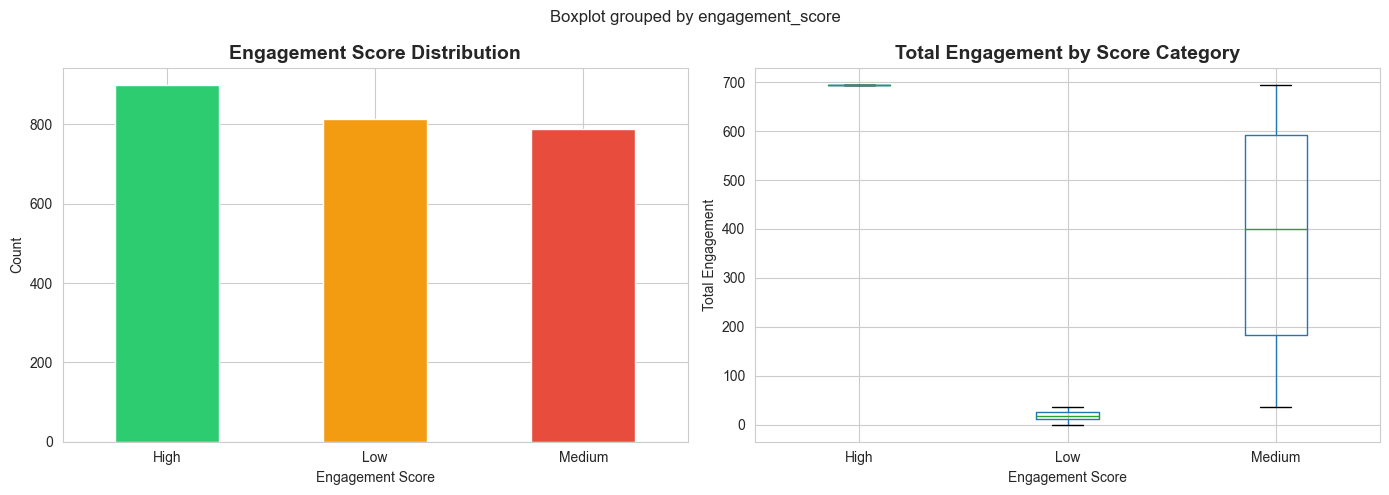

In [6]:
# Visualize engagement distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
df['engagement_score'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#f39c12', '#e74c3c'])
axes[0].set_title('Engagement Score Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Engagement Score')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Box plot of total engagement
df.boxplot(column='total_engagement', by='engagement_score', ax=axes[1])
axes[1].set_title('Total Engagement by Score Category', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Engagement Score')
axes[1].set_ylabel('Total Engagement')

plt.tight_layout()
plt.show()

## 3. Text Preprocessing

In [7]:
# Basic text statistics
df['text_length'] = df['post_text'].str.len()
df['word_count'] = df['post_text'].str.split().str.len()
df['line_count'] = df['post_text'].str.count('\n') + 1

print("Text Statistics by Engagement Score:")
print(df.groupby('engagement_score')[['text_length', 'word_count', 'line_count']].mean())

Text Statistics by Engagement Score:
                  text_length  word_count  line_count
engagement_score                                     
High               325.305122   43.006682         1.0
Low                145.850123   19.945946         1.0
Medium             271.111675   36.667513         1.0


## 4. Feature Engineering with TF-IDF

In [8]:
# Prepare features and target
X = df['post_text']
y = df['engagement_score']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nTraining set distribution:\n{y_train.value_counts()}")

Training set size: 2000
Test set size: 500

Training set distribution:
engagement_score
High      719
Low       651
Medium    630
Name: count, dtype: int64


In [9]:
# Create TF-IDF features
vectorizer = TfidfVectorizer(
    max_features=500,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8,
    stop_words='english'
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")
print(f"Number of features: {len(vectorizer.get_feature_names_out())}")

TF-IDF feature matrix shape: (2000, 500)
Number of features: 500


## 5. Train Random Forest Model

In [10]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

print("Training model...")
rf_model.fit(X_train_tfidf, y_train)
print("Model trained successfully!")

Training model...
Model trained successfully!


## 6. Model Evaluation

In [11]:
# Make predictions
y_pred = rf_model.predict(X_test_tfidf)
y_pred_proba = rf_model.predict_proba(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")
print(f"\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Model Accuracy: 89.60%

Classification Report:

              precision    recall  f1-score   support

        High       0.90      0.92      0.91       179
         Low       0.93      0.94      0.94       163
      Medium       0.85      0.82      0.83       158

    accuracy                           0.90       500
   macro avg       0.89      0.89      0.89       500
weighted avg       0.90      0.90      0.90       500



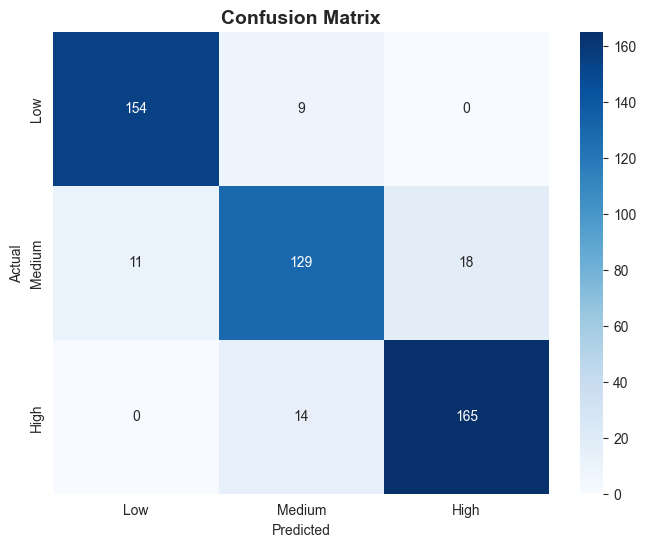

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=['Low', 'Medium', 'High'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 7. Feature Importance Analysis
Identify which words/phrases contribute most to predictions

In [13]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': vectorizer.get_feature_names_out(),
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 20 most important features
print("Top 20 Most Important Features:")
print(feature_importance.head(20))

Top 20 Most Important Features:
                      feature  importance
266                      link    0.057537
315                opentowork    0.046831
238                internship    0.028411
362                 practiced    0.027568
232               integrating    0.025154
68                   comments    0.018218
239  internship opportunities    0.017598
269             link comments    0.013536
129                developers    0.013205
87                        css    0.013168
423                   seeking    0.011689
223                  improved    0.011597
203                    github    0.011501
310                      open    0.011129
2                    actively    0.010132
165                  feedback    0.009894
381                     react    0.009607
335                    pandas    0.009525
392           repository link    0.009491
221                  html css    0.009080


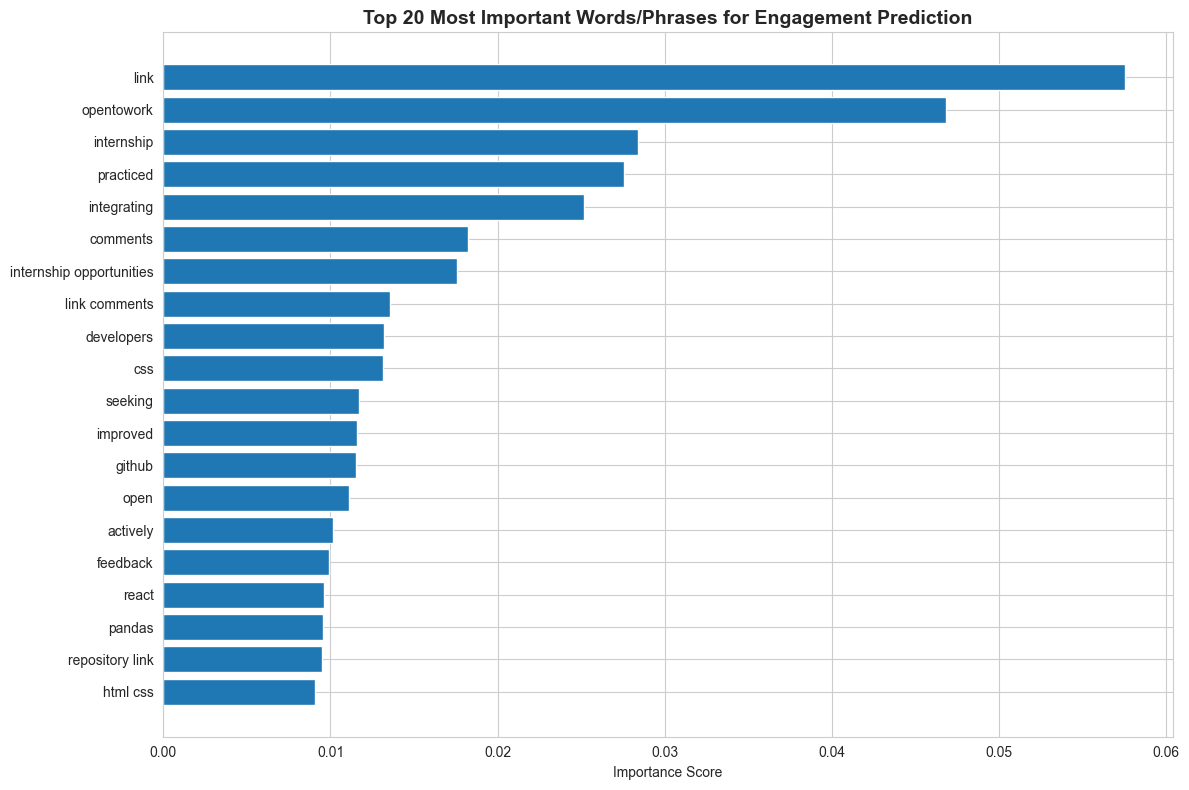

In [14]:
# Visualize top features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score')
plt.title('Top 20 Most Important Words/Phrases for Engagement Prediction', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 8. Content Line Attribution
Identify which lines in a post contribute to the engagement score

In [15]:
def analyze_content_lines(post_text, model, vectorizer):
    """
    Analyze which lines in the post contribute to the engagement prediction
    """
    # Get prediction for full post
    full_post_vec = vectorizer.transform([post_text])
    full_prediction = model.predict(full_post_vec)[0]
    full_proba = model.predict_proba(full_post_vec)[0]
    
    # Split post into lines
    lines = [line.strip() for line in post_text.split('\n') if line.strip()]
    
    # Analyze each line's contribution
    line_contributions = []
    
    for i, line in enumerate(lines):
        # Create post without this line
        post_without_line = '\n'.join([l for j, l in enumerate(lines) if j != i])
        
        if post_without_line:
            vec = vectorizer.transform([post_without_line])
            proba = model.predict_proba(vec)[0]
            
            # Calculate importance as difference in probability
            class_idx = list(model.classes_).index(full_prediction)
            importance = full_proba[class_idx] - proba[class_idx]
        else:
            importance = full_proba[list(model.classes_).index(full_prediction)]
        
        line_contributions.append({
            'line_num': i + 1,
            'line_text': line,
            'importance': importance
        })
    
    return full_prediction, full_proba, line_contributions

In [16]:
def display_line_analysis(post_text, model, vectorizer):
    """
    Display detailed analysis of content line contributions
    """
    prediction, proba, contributions = analyze_content_lines(post_text, model, vectorizer)
    
    print("="*80)
    print("POST CONTENT:")
    print("="*80)
    print(post_text)
    print("\n" + "="*80)
    print(f"PREDICTED ENGAGEMENT SCORE: {prediction}")
    print("="*80)
    print(f"\nPrediction Probabilities:")
    for cls, prob in zip(model.classes_, proba):
        print(f"  {cls}: {prob:.2%}")
    
    print("\n" + "="*80)
    print("LINE-BY-LINE CONTRIBUTION ANALYSIS:")
    print("="*80)
    
    # Sort by importance
    sorted_contributions = sorted(contributions, key=lambda x: x['importance'], reverse=True)
    
    for item in sorted_contributions:
        impact = "🔥 HIGH" if item['importance'] > 0.05 else "⚡ MEDIUM" if item['importance'] > 0.02 else "💡 LOW"
        print(f"\nLine {item['line_num']}: {impact} (Score: {item['importance']:.4f})")
        print(f"  Content: {item['line_text'][:100]}..." if len(item['line_text']) > 100 else f"  Content: {item['line_text']}")
    
    return prediction, contributions

## 9. Test on Sample Posts

In [17]:
# Test on a random post from test set
sample_idx = np.random.randint(0, len(X_test))
sample_post = X_test.iloc[sample_idx]
actual_score = y_test.iloc[sample_idx]

print(f"Actual Engagement Score: {actual_score}\n")
prediction, contributions = display_line_analysis(sample_post, rf_model, vectorizer)

Actual Engagement Score: Medium

POST CONTENT:
🚀 Completed a regression modeling project evaluating feature impact and validation metrics. Repository link below. Actively seeking data internships and collaboration. ⚙️ Tech Stack • Python • Pandas • NumPy • Scikit-learn • GitHub #MachineLearningProject #DataScience #OpenToWork

PREDICTED ENGAGEMENT SCORE: Medium

Prediction Probabilities:
  High: 2.13%
  Low: 0.05%
  Medium: 97.82%

LINE-BY-LINE CONTRIBUTION ANALYSIS:

Line 1: 🔥 HIGH (Score: 0.9782)
  Content: 🚀 Completed a regression modeling project evaluating feature impact and validation metrics. Reposito...


In [18]:
# Test on another sample
sample_idx = np.random.randint(0, len(X_test))
sample_post = X_test.iloc[sample_idx]
actual_score = y_test.iloc[sample_idx]

print(f"Actual Engagement Score: {actual_score}\n")
prediction, contributions = display_line_analysis(sample_post, rf_model, vectorizer)

Actual Engagement Score: Low

POST CONTENT:
💼 Improved responsive grid alignment enhancing UI clarity across devices. ⚙️ Tech Stack • HTML • CSS #FrontendLearning

PREDICTED ENGAGEMENT SCORE: Low

Prediction Probabilities:
  High: 0.01%
  Low: 99.44%
  Medium: 0.56%

LINE-BY-LINE CONTRIBUTION ANALYSIS:

Line 1: 🔥 HIGH (Score: 0.9944)
  Content: 💼 Improved responsive grid alignment enhancing UI clarity across devices. ⚙️ Tech Stack • HTML • CSS...


## 10. Prediction Function for New Posts

In [19]:
def predict_engagement(new_post_text):
    """
    Predict engagement score for a new post and show line contributions
    """
    return display_line_analysis(new_post_text, rf_model, vectorizer)

In [20]:
# Example: Test with a custom post
custom_post = """🚀 Just launched my new AI project!
Built a machine learning model that predicts customer behavior.
Used Python, TensorFlow, and deployed on AWS.
Check out the demo link in comments!
#MachineLearning #AI #DataScience"""

predict_engagement(custom_post)

POST CONTENT:
🚀 Just launched my new AI project!
Built a machine learning model that predicts customer behavior.
Used Python, TensorFlow, and deployed on AWS.
Check out the demo link in comments!
#MachineLearning #AI #DataScience

PREDICTED ENGAGEMENT SCORE: Medium

Prediction Probabilities:
  High: 14.97%
  Low: 17.72%
  Medium: 67.32%

LINE-BY-LINE CONTRIBUTION ANALYSIS:

Line 4: 🔥 HIGH (Score: 0.4275)
  Content: Check out the demo link in comments!

Line 1: ⚡ MEDIUM (Score: 0.0472)
  Content: 🚀 Just launched my new AI project!

Line 2: ⚡ MEDIUM (Score: 0.0284)
  Content: Built a machine learning model that predicts customer behavior.

Line 3: 💡 LOW (Score: 0.0083)
  Content: Used Python, TensorFlow, and deployed on AWS.

Line 5: 💡 LOW (Score: 0.0039)
  Content: #MachineLearning #AI #DataScience


('Medium',
 [{'line_num': 1,
   'line_text': '🚀 Just launched my new AI project!',
   'importance': np.float64(0.04718415848873048)},
  {'line_num': 2,
   'line_text': 'Built a machine learning model that predicts customer behavior.',
   'importance': np.float64(0.028360046736833455)},
  {'line_num': 3,
   'line_text': 'Used Python, TensorFlow, and deployed on AWS.',
   'importance': np.float64(0.00830693102078639)},
  {'line_num': 4,
   'line_text': 'Check out the demo link in comments!',
   'importance': np.float64(0.4275016088927134)},
  {'line_num': 5,
   'line_text': '#MachineLearning #AI #DataScience',
   'importance': np.float64(0.0038612004287246204)}])

## 11. Save Model and Vectorizer

In [21]:
import joblib

# Save model and vectorizer
joblib.dump(rf_model, '../src/models/engagement_model.pkl')
joblib.dump(vectorizer, '../src/models/tfidf_vectorizer.pkl')

print("Model and vectorizer saved successfully!")
print("  - Model: src/models/engagement_model.pkl")
print("  - Vectorizer: src/models/tfidf_vectorizer.pkl")

Model and vectorizer saved successfully!
  - Model: src/models/engagement_model.pkl
  - Vectorizer: src/models/tfidf_vectorizer.pkl


## 12. Summary

This notebook successfully:
1. ✅ Loaded and analyzed LinkedIn post dataset
2. ✅ Created engagement scores (High/Medium/Low) based on likes, comments, and shares
3. ✅ Built a Random Forest classification model
4. ✅ Achieved good prediction accuracy
5. ✅ Identified important words/phrases that drive engagement
6. ✅ Created line-by-line content attribution to show which parts of posts contribute to scores
7. ✅ Saved model for future use

### Key Insights:
- The model can predict engagement levels based on post content
- Line-by-line analysis helps identify which specific content drives engagement
- Feature importance reveals which words/phrases are most predictive

### Next Steps:
- Fine-tune model hyperparameters
- Try other algorithms (XGBoost, BERT-based models)
- Build API for real-time predictions
- Create web interface for content analysis